## ON THE INTERPRETATION OF LEARNING DYNAMICAL SYSTEMS
## Example: Flow past the cylinder

In [41]:
#---------------------------------------
# Load Libs
#---------------------------------------
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm
plt.style.use('seaborn-paper')
#print(plt.style.available)
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

import cmocean

from itertools import cycle
from collections import defaultdict

In [2]:
#---------------------------------------
# Load utility functions
#---------------------------------------
import importlib
import utils 
importlib.reload(utils)
from utils import *

import helper 
importlib.reload(helper)
from helper import *

In [3]:
#---------------------------------------
# Load torch
#---------------------------------------
import torch
device = get_device()

Connected to a GPU


In [4]:
#---------------------------------------
# Set seed
#---------------------------------------
import torch.nn.init as init
np.random.seed(10)
torch.manual_seed(10)

## Example 1: The Simple Harmonic Oscillator 

In [5]:
#---------------------------------------
# Example: Simple flow past a cylinder
# Load Data
#---------------------------------------

data = np.load('data/flow_cylinder.npy')
    
# Split into train and test set
t, m, n = data.shape

data = data.reshape(151,-1)
print(data.shape)

# Center data
data -= np.mean(data, axis=0)
  

N_time_step = 151
dt = 0.2


(151, 89351)


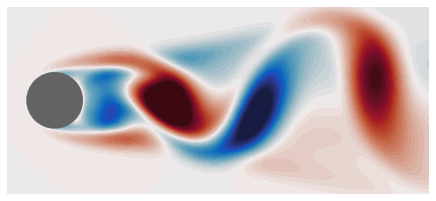

In [92]:
def plot_flow(X, m, n):
    X = X.reshape(m,n)

    x2 = np.arange(0, m, 1)
    y2 = np.arange(0, n, 1)
    mX, mY = np.meshgrid(x2, y2)

    minmax = np.max(np.abs(X)) * 0.65
    #plt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    im = plt.imshow(X.T, cmap=cmocean.cm.balance, interpolation='bicubic', vmin=-minmax, vmax=minmax)
    plt.contourf(mX, mY, X.T, 90, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
    
    
    circ=plt.Circle((50,99), radius=30, color='#636363', fill=True)
    im.axes.add_patch(circ)   
        
    plt.axis('off')
    plt.tight_layout()
    #plt.show()
    #plt.close()
    
    

plot_flow(data[0,:], m, n)    

In [7]:
#---------------------------------------
# Project data
#---------------------------------------
k = 3
u, _, _ = np.linalg.svd(data.T, False)

proj_data = u[:,0:k].T.dot(data.T)


# send to torch
torch_data = data_to_torch(proj_data.T, device)

In [8]:
torch_data.shape

torch.Size([151, 3])

In [56]:
def learn_lambda(data, batch_size=32, n_future=1, verbose=False,
    methods=('FW','BW','TR'), device=None, dt=1):
    """Perform the one-step learning for a linear matrix."""
    if device is None:
        device = get_device()

    k = data.shape[1]
   
    N_iter = 1000
    N_print = N_iter+1 #//10
    nsamp = data.shape[0]

    
    model = torch.nn.Linear(3, 3, bias=False).double().to(device)
    optim = torch.optim.Adam(model.parameters(),lr = 1e-2, weight_decay = 0)
    loss = torch.nn.MSELoss()
    losses=[]

    
    
    I = torch.eye(k, dtype=torch.double, device=device)
    fwstep = lambda model, y : y + dt*model(y)
    bwstep = lambda model, y : torch.einsum("ij,aj->ai",torch.inverse(I - dt*model.weight), y)
    trstep = lambda model, y : torch.einsum("ij,aj->ai",torch.inverse(I-0.5*dt*model.weight), ( y + 0.5*dt*model(y) ))



    
    for opt_iter in range(N_iter):
        idcs = torch.LongTensor(np.random.choice(nsamp-n_future, size=batch_size)).to(device)
        yy = [ torch.index_select(data,0,idcs+i) for i in range(n_future+1) ]
        y_pred_fw = fwstep(model, yy[0])
        y_pred_bw = bwstep(model, yy[0])
        y_pred_tr = trstep(model, yy[0])

        if methods == ('FW','BW','TR'):
            L = loss(yy[1], y_pred_fw) + loss(yy[1], y_pred_bw) + loss(yy[1], y_pred_tr)
        elif methods == ('FW','BW'):
            L = loss(yy[1], y_pred_fw) + loss(yy[1], y_pred_bw)
        elif methods == ('FW',):
            L = loss(yy[1], y_pred_fw)
        elif methods == ('BW','TR'):
            L = loss(yy[1], y_pred_bw) + loss(yy[1], y_pred_tr)
        elif methods == ('BW',):
            L = loss(yy[1], y_pred_bw)
        else:
            L = loss(yy[1], y_pred_tr)

        optim.zero_grad()
        L.backward()
        optim.step()
        losses.append(L)
        if verbose and opt_iter%N_print==N_print-1:
            print(opt_iter,L.item())
            print(list(model.parameters()))
            #do_a_path_and_plot(model, trstep, ylim=None,nsteps=1000) # This is wrong now

        exp_lr_scheduler(optim, opt_iter, lr_decay_rate=0.3, decayEpoch=[100, 200, 600])



    if verbose:
        print("Converged with L1: ",losses[-1])

    nump_mat = model.weight.data.cpu().numpy()
    op_tr = np.linalg.inv(np.eye(k) - 0.5*dt*nump_mat).dot( np.eye(k) + 0.5*dt*nump_mat )
    op_fw = np.eye(k) + dt*nump_mat
    op_bw = np.linalg.inv(np.eye(k) - dt*nump_mat)
    return model, np.array([l.cpu().detach().numpy() for l in losses]), nump_mat, op_tr, op_fw, op_bw


In [57]:
all_method_combos = [
    ('FW','BW','TR'),
    ('FW',),
    ('BW',),
    ('TR',)
]
results = {}
for methods in all_method_combos:
    results[methods] = learn_lambda(torch_data, batch_size=50, verbose=True, 
                                    n_future=3, device=device, methods=methods, dt=dt)

Converged with L1:  tensor(245.7895, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
Converged with L1:  tensor(86.9179, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Converged with L1:  tensor(92.6370, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Converged with L1:  tensor(87.2418, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


In [58]:
torch_data.shape

torch.Size([151, 3])

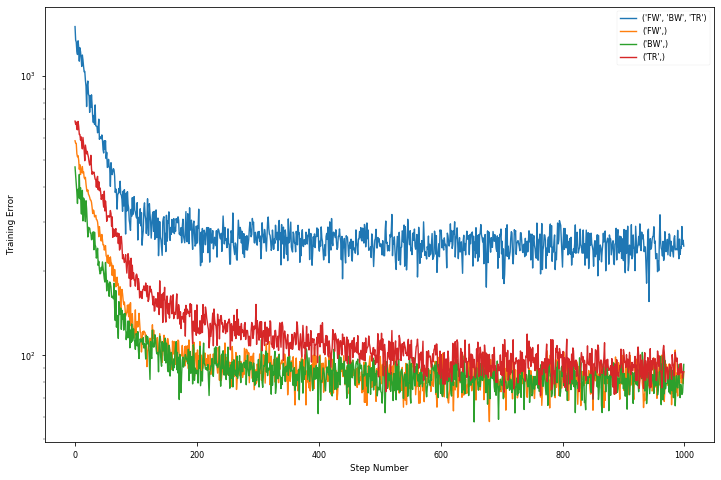

In [59]:
plt.rcParams.update({'font.size':18})
plt.figure(figsize=(12,8))
for k,(model,loss,mat,tr,fw,bw) in results.items():
    plt.semilogy(loss,label=k)
plt.ylabel('Training Error')
plt.xlabel('Step Number')
plt.legend()
plt.show()

## Everythiing below needs to be cleaned up....

In [60]:
good_lambda = results[('FW','BW','TR')][2]
FW_lambda = results[('FW',)][2]
BW_lambda = results[('BW',)][2]
TR_lambda = results[('TR',)][2]

print(good_lambda)

[[-3.48311281e-03 -9.83989139e-01 -8.71076962e-03]
 [ 1.02034135e+00 -1.92627791e-03  8.64516757e-04]
 [ 1.93918778e-03 -2.05892712e-02 -4.03832001e-01]]


In [61]:
anal_ts = np.arange(0, 150*0.2, 0.2)

array([  67.29955862, -131.57298987,   13.77009081])

In [62]:
u0 = proj_data.T[0,:]

data_est0 = solution_general_linear(Lambda=good_lambda, u0=u0, ts=anal_ts)

data_est1 = solution_general_linear(Lambda=FW_lambda, u0=u0, ts=anal_ts)

data_est2 = solution_general_linear(Lambda=BW_lambda, u0=u0, ts=anal_ts)

data_est3 = solution_general_linear(Lambda=TR_lambda, u0=u0, ts=anal_ts)


#data_est1 = solution_general_linear(Lambda=good_lambda, u0=u1, ts=anal_ts)
              
#data_est2 = solution_general_linear(Lambda=good_lambda, u0=u2, ts=anal_ts)              

Text(0.5, 1.0, 'TR')

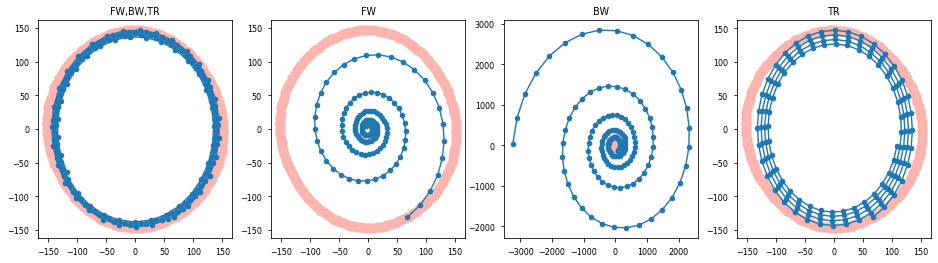

In [66]:
FIG_SIZE_FULL = (16,4)
plt.figure(figsize=FIG_SIZE_FULL)
plt.subplot(1,4,1)
plt.scatter(proj_data.T[:,0], proj_data.T[:,1], c='#fbb4ae', label='True solution', s=100)
plt.plot(data_est0[:,0], data_est0[:,1], '-o', c='#1f78b4', label='Estimated solution')
plt.title('FW,BW,TR')

plt.subplot(1,4,2)
plt.scatter(proj_data.T[:,0], proj_data.T[:,1], c='#fbb4ae', label='True solution', s=100)
plt.plot(data_est1[:,0], data_est1[:,1], '-o', c='#1f78b4', label='Estimated solution')
plt.title('FW')

plt.subplot(1,4,3)
plt.scatter(proj_data.T[:,0], proj_data.T[:,1], c='#fbb4ae', label='True solution', s=100)
plt.plot(data_est2[:,0], data_est2[:,1], '-o', c='#1f78b4', label='Estimated solution')
plt.title('BW')

plt.subplot(1,4,4)
plt.scatter(proj_data.T[:,0], proj_data.T[:,1], c='#fbb4ae', label='True solution', s=100)
plt.plot(data_est3[:,0], data_est3[:,1], '-o', c='#1f78b4', label='Estimated solution')

plt.title('TR')

#plt.ylim(-3.5, 3.5)
#plt.xlim(-3.5, 3.5)
#plt.legend(fontsize=22)


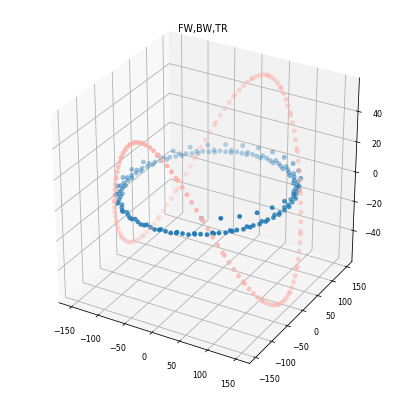

In [64]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(proj_data.T[:,0], proj_data.T[:,1], proj_data.T[:,2], c='#fbb4ae', label='True solution')
ax.scatter(data_est0[:,0], data_est0[:,1], data_est0[:,2], c='#1f78b4', label='Estimated solution')

plt.title('FW,BW,TR')
plt.show()

In [73]:
data_est0.shape

(150, 3)

In [103]:
true_data_lowr = proj_data.T[:,0:2].dot(u[:,0:2].T)
approx_data_lowr = data_est0[:,0:2].dot(u[:,0:2].T)
approx_data_lowr_tr = data_est3[:,0:2].dot(u[:,0:2].T)

Text(0.5, 1, 'TR')

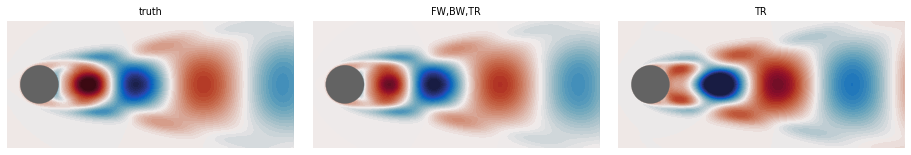

In [107]:
FIG_SIZE_FULL = (13,4)
plt.figure(figsize=FIG_SIZE_FULL)
plt.subplot(1,3,1)
plot_flow(true_data_lowr[50,:], m, n)  
plt.title('truth')

plt.subplot(1,3,2)
plot_flow(approx_data_lowr[50,:], m, n)  
plt.title('FW,BW,TR')

plt.subplot(1,3,3)
plot_flow(approx_data_lowr_tr[50,:], m, n)  
plt.title('TR')
